* Importação das bibliotecas necessárias:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")


# 1. Coletando e tratando os dados:

In [3]:
# Coletando dados da VALE3 e formatando o DataFrame:
vale = yf.download('VALE3.SA', start='2022-01-01', end='2025-06-01', multi_level_index=False)
vale = vale[['Close', 'Open', 'Volume']]
vale.reset_index(inplace=True)
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)

# Criando um DataFrame para armazenar os dados do minério de ferro:
minerio_ferro = pd.read_csv(
    "Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv"
    )
minerio_ferro.reset_index(inplace=True)
minerio_ferro['Data'] = pd.to_datetime(minerio_ferro['Data'], dayfirst=True)
minerio_ferro.set_index('Data', inplace=True)
minerio_ferro = minerio_ferro[['Último','Abertura', 'Var%']]
# invertendo a ordem das datas:
minerio_ferro = minerio_ferro.iloc[::-1]
minerio_ferro.rename(columns={
    'Último': 'Close',
    'Abertura': 'Open',
    'Var%': 'Variação'
}, inplace=True)

# Unindo os DataFrames de VALE3 e minério de ferro:
df = pd.merge(vale, minerio_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Minerio'))
df.rename(columns={
    'Close_VALE3': 'Close_VALE3',
    'Open_VALE3': 'Open_VALE3',
    'Volume': 'Volume_VALE3',
    'Close_Minerio': 'Close_Minerio',
    'Open_Minerio': 'Open_Minerio',
    'Variação': 'Variação_Minerio'
}, inplace=True)

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df['Close_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Minerio'] = df['Close_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Open_Minerio'] = df['Open_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Variação_Minerio'] = df['Variação_Minerio'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Variação percentual do preço de fechamento do minério de ferro:
df['Variação_Minerio'] = df['Close_Minerio'].pct_change() * 100 
# Trocando nan por 7,02%:
df['Variação_Minerio'].fillna(7.02, inplace=True)

df

[*********************100%***********************]  1 of 1 completed


,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3
2022-01-03,59.548798,60.312244,18557200,120.40,120.40,7.020000,0.000000
2022-01-04,58.846436,59.938164,18178700,120.91,120.91,0.423588,-1.179473
2022-01-05,59.403751,59.067839,22039000,124.14,124.14,2.671408,0.947068
2022-01-06,60.602348,60.037400,22044100,125.94,125.94,1.449976,2.017713
2022-01-07,64.129471,61.381066,35213100,126.21,126.21,0.214388,5.820109
...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894


# 2. Fetures temporais.

In [4]:
# Vamos adicionar as fetures de dias, semanas, meses, anos e calcular o seno e o cosseno do mês para capturar sazonalidade cíclica:
df['Dia'] = df.index.day
df['Semana'] = df.index.weekday
df['Mês'] = df.index.month
df['Ano'] = df.index.year

df['Sin_Mês'] = np.sin(2 * np.pi * df['Mês'] / 12)
df['Cos_Mês'] = np.cos(2 * np.pi * df['Mês'] / 12)

# Vamos adicionar médias móveis de 20 e 200 dias no preço de fechamento da VALE3 e do minério de ferro:
df['MM_20D_VALE3'] = df['Close_VALE3'].rolling(window=20, min_periods=1).mean()
df['MM_200D_VALE3'] = df['Close_VALE3'].rolling(window=200, min_periods=1).mean()
df['MM_20D_MF'] = df['Close_Minerio'].rolling(window=20, min_periods=1).mean()
df['MM_200D_MF'] = df['Close_Minerio'].rolling(window=200, min_periods=1).mean()

# Coluna do preço anterior(D-1):
df['Close_VALE3_D-1'] = df['Close_VALE3'].shift(1)
df['Close_VALE3_D-1'].fillna(0, inplace=True)

df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,Ano,Sin_Mês,Cos_Mês,MM_20D_VALE3,MM_200D_VALE3,MM_20D_MF,MM_200D_MF,Close_VALE3_D-1
2022-01-03,59.548798,60.312244,18557200,120.40,120.40,7.020000,0.000000,3,0,1,2022,0.5,0.866025,59.548798,59.548798,120.400000,120.400000,0.000000
2022-01-04,58.846436,59.938164,18178700,120.91,120.91,0.423588,-1.179473,4,1,1,2022,0.5,0.866025,59.197617,59.197617,120.655000,120.655000,59.548798
2022-01-05,59.403751,59.067839,22039000,124.14,124.14,2.671408,0.947068,5,2,1,2022,0.5,0.866025,59.266328,59.266328,121.816667,121.816667,58.846436
2022-01-06,60.602348,60.037400,22044100,125.94,125.94,1.449976,2.017713,6,3,1,2022,0.5,0.866025,59.600333,59.600333,122.847500,122.847500,59.403751
2022-01-07,64.129471,61.381066,35213100,126.21,126.21,0.214388,5.820109,7,4,1,2022,0.5,0.866025,60.506161,60.506161,123.520000,123.520000,60.602348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,2025,0.5,-0.866025,54.055500,54.977746,99.505000,101.648300,54.230000
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,2025,0.5,-0.866025,54.055000,54.964091,99.483000,101.611400,54.320000
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,2025,0.5,-0.866025,54.023500,54.947780,99.457000,101.575400,53.840000
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,2025,0.5,-0.866025,54.004000,54.937926,99.427500,101.540500,53.410000


* Visualizando series temporais:

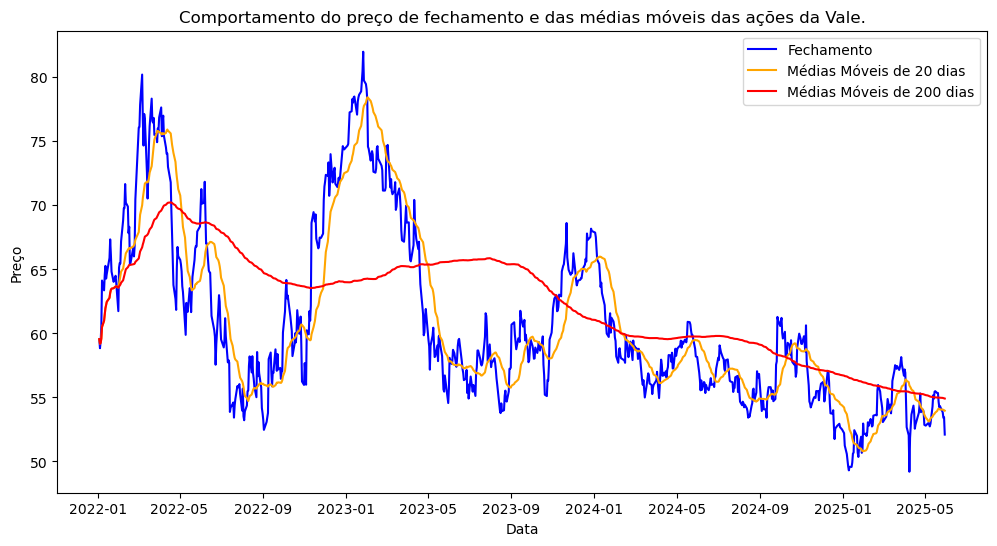

In [5]:
# Vamos visualizar o comportamento de fechamento e médias móveis das ações da VALE:

plt.figure(figsize=(12,6))
plt.plot(df['Close_VALE3'], label='Fechamento', color='blue')
plt.plot(df['MM_20D_VALE3'], label='Médias Móveis de 20 dias', color='orange')
plt.plot(df['MM_200D_VALE3'], label='Médias Móveis de 200 dias', color='red')
plt.title('Comportamento do preço de fechamento e das médias móveis das ações da Vale.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

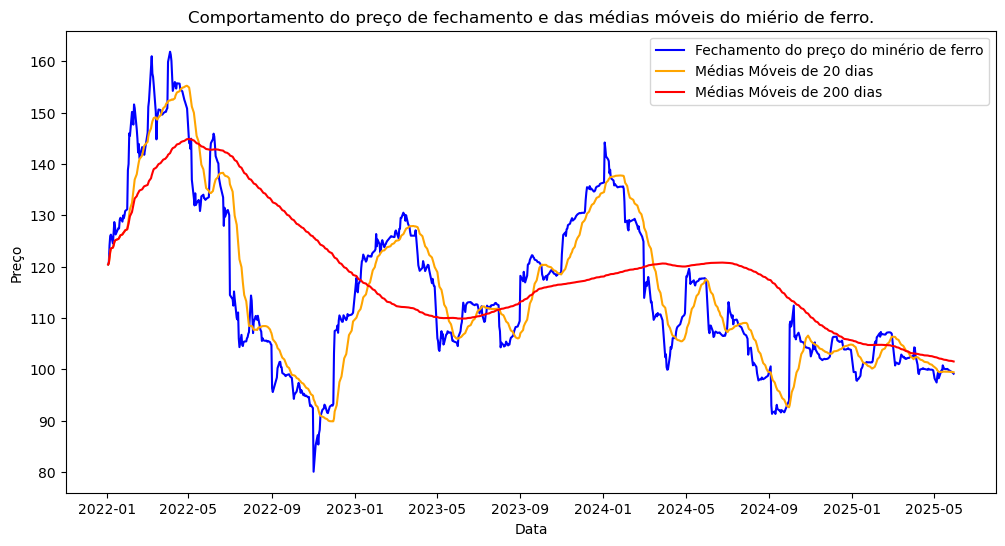

In [6]:
# Vamos visualizar o comportamento de abertura, fechamento e médias móveis das ações do minério de ferro:

plt.figure(figsize=(12,6))
plt.plot(df['Close_Minerio'], label='Fechamento do preço do minério de ferro', color='blue')
plt.plot(df['MM_20D_MF'], label='Médias Móveis de 20 dias', color='orange')
plt.plot(df['MM_200D_MF'], label='Médias Móveis de 200 dias', color='red')
plt.title('Comportamento do preço de fechamento e das médias móveis do miério de ferro.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

# 3. Decomposição da Serie Temporal.

In [7]:
decomposicao = seasonal_decompose(df['Close_VALE3'], model='multiplicative', period=30)
df['Tendencia'] = decomposicao.trend
df['Sazonalidade'] = decomposicao.seasonal
df['Residuo'] = decomposicao.resid

# Preencher valores ausentes resultantes da decomposição:
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# 4. Lags e Rolling Statistics.

* Vamos criar colunas que trazem o preço de fechamento e o retorno percentual de ontem, anteontem, etc. Assim o modelo “vê” vários dias anteriores:

In [8]:
lags = [1, 2, 3, 4, 5] # dias de atraso

for lag in lags:
    df[f'Close_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Preço do fechamento lagado
    df[f'Ret_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Retorno percentual lagado

* Agora, para captar tendências e volatilidade de curto e médio prazo, vamos criar médias móveis de curto prazo e estatísticas móveis (desvio, assimetria, curtose) em janelas de vários tamanhos:

In [9]:
windows = [5, 10, 15, 30, 50] # Janelas de dias

for w in windows:
    # Média móvel
    df[f'MM_de_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).mean()
    # Desvio-padrão móvel dos retornos em w dias
    df[f'Desvio_Padrao_de_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).std()
    # Assimetria móvel dos retornos
    df[f'roll_skew_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).skew()
    # Curtose móvel dos retornos
    df[f'Curtose_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).kurt()
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,...,roll_skew_15,Curtose_15,MM_de_30,Desvio_Padrao_de_30,roll_skew_30,Curtose_30,MM_de_50,Desvio_Padrao_de_50,roll_skew_50,Curtose_50
2022-01-03,59.548798,60.312244,18557200,120.40,120.40,7.020000,0.000000,3,0,1,...,NaN,NaN,59.548798,NaN,NaN,NaN,59.548798,NaN,NaN,NaN
2022-01-04,58.846436,59.938164,18178700,120.91,120.91,0.423588,-1.179473,4,1,1,...,NaN,NaN,59.197617,0.496645,NaN,NaN,59.197617,0.496645,NaN,NaN
2022-01-05,59.403751,59.067839,22039000,124.14,124.14,2.671408,0.947068,5,2,1,...,-1.438687,NaN,59.266328,0.370799,-1.438687,NaN,59.266328,0.370799,-1.438687,NaN
2022-01-06,60.602348,60.037400,22044100,125.94,125.94,1.449976,2.017713,6,3,1,...,0.962961,1.852675,59.600333,0.733416,0.962961,1.852675,59.600333,0.733416,0.962961,1.852675
2022-01-07,64.129471,61.381066,35213100,126.21,126.21,0.214388,5.820109,7,4,1,...,1.776402,3.220448,60.506161,2.122744,1.776402,3.220448,60.506161,2.122744,1.776402,3.220448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,...,-0.324580,-1.637176,53.886667,1.031050,0.026033,-1.077892,54.707800,1.957700,-0.092500,-0.233223
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,...,-0.414413,-1.341707,53.953000,0.956845,0.165655,-1.250139,54.709400,1.956942,-0.094601,-0.228681
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,...,-0.421093,-1.216086,53.974000,0.936919,0.169704,-1.187451,54.687600,1.965375,-0.064842,-0.278782
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,...,-0.394918,-1.104977,53.967000,0.940125,0.186887,-1.207078,54.630800,1.959149,0.008174,-0.252883


In [10]:
df = df.dropna()
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,...,roll_skew_15,Curtose_15,MM_de_30,Desvio_Padrao_de_30,roll_skew_30,Curtose_30,MM_de_50,Desvio_Padrao_de_50,roll_skew_50,Curtose_50
2022-01-10,63.366013,62.976654,25056700,124.48,124.48,-1.370731,-1.190495,10,0,1,...,0.758627,-1.666750,60.982803,2.228892,0.758627,-1.666750,60.982803,2.228892,0.758627,-1.666750
2022-01-11,64.572273,63.732484,28418800,126.75,126.75,1.823586,1.903640,11,1,1,...,0.288824,-2.355130,61.495584,2.445522,0.288824,-2.355130,61.495584,2.445522,0.288824,-2.355130
2022-01-12,65.274643,66.030453,27335400,128.66,128.66,1.506903,1.087726,12,2,1,...,0.027984,-2.264993,61.967967,2.628949,0.027984,-2.264993,61.967967,2.628949,0.027984,-2.264993
2022-01-13,64.282173,64.770778,23154200,127.84,127.84,-0.637339,-1.520452,13,3,1,...,-0.244850,-2.134052,62.225101,2.577307,-0.244850,-2.134052,62.225101,2.577307,-0.244850,-2.134052
2022-01-14,64.656250,63.915706,21183400,126.24,126.24,-1.251564,0.581929,14,4,1,...,-0.457188,-1.914946,62.468216,2.548628,-0.457188,-1.914946,62.468216,2.548628,-0.457188,-1.914946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,...,-0.324580,-1.637176,53.886667,1.031050,0.026033,-1.077892,54.707800,1.957700,-0.092500,-0.233223
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,...,-0.414413,-1.341707,53.953000,0.956845,0.165655,-1.250139,54.709400,1.956942,-0.094601,-0.228681
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,...,-0.421093,-1.216086,53.974000,0.936919,0.169704,-1.187451,54.687600,1.965375,-0.064842,-0.278782
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,...,-0.394918,-1.104977,53.967000,0.940125,0.186887,-1.207078,54.630800,1.959149,0.008174,-0.252883


# 5. Indicadores Técnicos.

In [11]:
# Média móvel exponencial de 20 dias:
df['MME_20D'] = df['Close_VALE3'].ewm(span=20, adjust=False).mean()
# Média móvel exponencial de 200 dias:
df['MME_200D'] = df['Close_VALE3'].ewm(span=200, adjust=False).mean()

df[['MME_20D', 'MME_200D']]

,MME_20D,MME_200D
2022-01-10,63.366013,63.366013
2022-01-11,63.480895,63.378015
2022-01-12,63.651728,63.396887
2022-01-13,63.711770,63.405696
2022-01-14,63.801721,63.418139
...,...,...
2025-05-23,54.362165,55.134049
2025-05-27,54.312435,55.121173
2025-05-28,54.226489,55.104146
2025-05-29,54.152537,55.087687


In [12]:
def calculo_rsi(series, window=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = calculo_rsi(df['Close_VALE3'], window=14)
df[['RSI_14']]

,RSI_14
2022-01-10,NaN
2022-01-11,NaN
2022-01-12,NaN
2022-01-13,NaN
2022-01-14,NaN
...,...
2025-05-23,63.709707
2025-05-27,57.777793
2025-05-28,54.450253
2025-05-29,56.327985


In [13]:
df['RSI_14'].fillna(df['RSI_14'].mean(), inplace=True)
df[['RSI_14']]

,RSI_14
2022-01-10,49.403628
2022-01-11,49.403628
2022-01-12,49.403628
2022-01-13,49.403628
2022-01-14,49.403628
...,...
2025-05-23,63.709707
2025-05-27,57.777793
2025-05-28,54.450253
2025-05-29,56.327985


In [14]:
MME_12 = df['Close_VALE3'].ewm(span=12, adjust=False).mean()
MME_26 = df['Close_VALE3'].ewm(span=26, adjust=False).mean()

df['MACD'] = MME_12 - MME_26

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df[['MACD', 'MACD_Signal']]

,MACD,MACD_Signal
2022-01-10,0.000000,0.000000
2022-01-11,0.096226,0.019245
2022-01-12,0.226550,0.060706
2022-01-13,0.246902,0.097945
2022-01-14,0.289874,0.136331
...,...,...
2025-05-23,0.198816,0.121362
2025-05-27,0.130217,0.123133
2025-05-28,0.040685,0.106644
2025-05-29,-0.026733,0.079968


In [15]:
# Calculando a média móvel e o desvio padrão
media_20 = df['Close_VALE3'].rolling(window=20, min_periods=1).mean()
desvio_20 = df['Close_VALE3'].rolling(window=20, min_periods=1).std()

# Calculando as bandas
df['Banda_Media'] = media_20
df['Banda_Superior'] = media_20 + (2 * desvio_20)
df['Banda_Inferior'] = media_20 - (2 * desvio_20)


df[['Banda_Media', 'Banda_Superior', 'Banda_Inferior']]

,Banda_Media,Banda_Superior,Banda_Inferior
2022-01-10,63.366013,NaN,NaN
2022-01-11,63.969143,65.675053,62.263233
2022-01-12,64.404310,66.334984,62.473635
2022-01-13,64.373775,65.954889,62.792662
2022-01-14,64.430270,65.822669,63.037872
...,...,...,...
2025-05-23,54.055500,56.080205,52.030795
2025-05-27,54.055000,56.079923,52.030077
2025-05-28,54.023500,56.068903,51.978097
2025-05-29,54.004000,56.064152,51.943848


# 6. Volatilidade e Risco.

* Volatilidade histórica:

In [16]:
# Retorno logarítmico diário:
df['LogRet'] = np.log(df['Close_VALE3'] / df['Close_VALE3'].shift(1))

# Volatilidade histórica em janelas móveis:
window = 30
df[f'Volatilidade_{window}'] = df['LogRet'].rolling(window=window, min_periods=1).std() * np.sqrt(252)

df[['LogRet']]

,LogRet
2022-01-10,NaN
2022-01-11,0.018857
2022-01-12,0.010819
2022-01-13,-0.015321
2022-01-14,0.005802
...,...
2025-05-23,0.001658
2025-05-27,-0.008876
2025-05-28,-0.008019
2025-05-29,0.000749


In [17]:
df['Volatilidade_30'].fillna(0, inplace=True)
df['LogRet'].fillna(0, inplace=True)

In [18]:
df[['LogRet']].isnull().sum()

LogRet    0
dtype: int64

* Rolling Shape Ratio:

In [19]:
# taxa livre de risco anual de 3% convertida para diária:
rf_daily = 0.03 / 252
window = 30

# Retorno excedente ao RF:
df['ExcessRet'] = df['LogRet'] - rf_daily

# Rolling mean e rolling std do excesso:
roll_mean_ex = df['ExcessRet'].rolling(window=window, min_periods=1).mean()
roll_std_ex = df['ExcessRet'].rolling(window=window, min_periods=1).std()

# Rolling Sharpe:
df[f'Sharpe_{window}d'] = roll_mean_ex / roll_std_ex

df[['ExcessRet', 'Sharpe_30d']]

,ExcessRet,Sharpe_30d
2022-01-10,-0.000119,NaN
2022-01-11,0.018738,0.698179
2022-01-12,0.010699,1.032774
2022-01-13,-0.015440,0.234657
2022-01-14,0.005683,0.304626
...,...,...
2025-05-23,0.001539,0.205892
2025-05-27,-0.008995,0.090941
2025-05-28,-0.008138,0.022656
2025-05-29,0.000630,-0.021134


In [20]:
df[['ExcessRet', 'Sharpe_30d']].isnull().sum()

ExcessRet     0
Sharpe_30d    1
dtype: int64

# 7 Interações e Razões:

In [21]:
df['Ratio_VALE3_Minerio'] = df['Close_VALE3'] / df['Close_Minerio']

In [22]:
df['Diff_VALE3_Minerio'] = df['Close_VALE3'] - df['Close_Minerio']
df[['Diff_VALE3_Minerio']]

,Diff_VALE3_Minerio
2022-01-10,-61.113987
2022-01-11,-62.177727
2022-01-12,-63.385357
2022-01-13,-63.557827
2022-01-14,-61.583750
...,...
2025-05-23,-45.490000
2025-05-27,-45.640000
2025-05-28,-45.980000
2025-05-29,-45.819999


In [23]:
df['Diff_Retorno_VALE3_Minerio'] = df['Variação_VALE3'] - df['Variação_Minerio']
df[['Diff_Retorno_VALE3_Minerio']].isnull().sum()

Diff_Retorno_VALE3_Minerio    0
dtype: int64

# 8. Pré-Seleção e Redução de Dimensionalidade.

In [26]:
# Primeiro criamos uma variável-alvo, nesse caso vamos pegar o preço do fechamento do dia seguinte:
df['Target_Close_D+1'] = df['Close_VALE3'].shift(-1)
df['Target_Close_D+1'].fillna(0, inplace=True)

# Agora vamos calcular a correlação de todas as colunas númericas com essa target:
correlacoes = df.corr(numeric_only=True)['Target_Close_D+1'].sort_values(ascending=False)

In [28]:
from sklearn.feature_selection import VarianceThreshold

# Seleciona só variáveis numéricas:
X_numerico = df.select_dtypes(include=[np.number]).drop(columns=['Target_Close_D+1'])

# Aplica filtro de variância com um limiar suave:
selector = VarianceThreshold(threshold=1e-5)
selector.fit(X_numerico)
x_filtrado_var = X_numerico.loc[:, selector.get_support()]

In [29]:
# Matriz de correlação:
corr_matriz = x_filtrado_var.corr().abs()

# Triângulo superior:
upper = corr_matriz.where(np.triu(np.ones(corr_matriz.shape), k=1).astype(bool))

# Identifica colunas muito correlacionadas (threshold de 0.95 para maior tolerância:
colunas_a_remover = [col for col in upper.columns if any(upper[col] > 0.95)]

# Remove do conjunto:
x_filtrado_corr = x_filtrado_var.drop(columns=colunas_a_remover)

In [30]:
# Junta com a target temporariamente
x_filtrado_corr['Target_Close_D+1'] = df['Target_Close_D+1']

# Calcula a correlação com a variável alvo
correlacoes = x_filtrado_corr.corr()['Target_Close_D+1'].abs().sort_values(ascending=False)

# Seleciona top N variáveis mais correlacionadas com o target (ex: top 25)
top_features = correlacoes.drop('Target_Close_D+1').head(25).index.to_list()

# Conjunto final
df_final = df[top_features + ['Target_Close_D+1']]

df_final

,Close_VALE3,MM_20D_VALE3,MME_200D,Close_Minerio,Desvio_Padrao_de_50,Ano,MM_200D_VALE3,MM_20D_MF,MACD_Signal,MACD,...,Volatilidade_30,Sin_Mês,Desvio_Padrao_de_5,RSI_14,Cos_Mês,Diff_VALE3_Minerio,Ratio_VALE3_Minerio,Mês,Variação_Minerio,Target_Close_D+1
2022-01-10,63.366013,60.982803,63.366013,124.48,2.228892,2022,60.982803,123.680000,0.000000,0.000000,...,0.000000,0.5,2.364960,49.403628,0.866025,-61.113987,0.509046,1,-1.370731,64.572273
2022-01-11,64.572273,61.495584,63.378015,126.75,2.445522,2022,61.495584,124.118571,0.019245,0.096226,...,0.000000,0.5,2.283144,49.403628,0.866025,-62.177727,0.509446,1,1.823586,65.274643
2022-01-12,65.274643,61.967967,63.396887,128.66,2.628949,2022,61.967967,124.686250,0.060706,0.226550,...,0.090237,0.5,1.807632,49.403628,0.866025,-63.385357,0.507342,1,1.506903,64.282173
2022-01-13,64.282173,62.225101,63.405696,127.84,2.577307,2022,62.225101,125.036667,0.097945,0.246902,...,0.283684,0.5,0.693305,49.403628,0.866025,-63.557827,0.502833,1,-0.637339,64.656250
2022-01-14,64.656250,62.468216,63.418139,126.24,2.548628,2022,62.468216,125.157000,0.136331,0.289874,...,0.231767,0.5,0.696199,49.403628,0.866025,-61.583750,0.512169,1,-1.251564,65.893028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.055500,55.134049,99.81,1.957700,2025,54.977746,99.505000,0.121362,0.198816,...,0.245252,0.5,0.541322,63.709707,-0.866025,-45.490000,0.544234,5,-0.080088,53.840000
2025-05-27,53.840000,54.055000,55.121173,99.48,1.956942,2025,54.964091,99.483000,0.123133,0.130217,...,0.198358,0.5,0.565711,57.777793,-0.866025,-45.640000,0.541214,5,-0.330628,53.410000
2025-05-28,53.410000,54.023500,55.104146,99.39,1.965375,2025,54.947780,99.457000,0.106644,0.040685,...,0.193722,0.5,0.474310,54.450253,-0.866025,-45.980000,0.537378,5,-0.090470,53.450001
2025-05-29,53.450001,54.004000,55.087687,99.27,1.959149,2025,54.937926,99.427500,0.079968,-0.026733,...,0.187599,0.5,0.423969,56.327985,-0.866025,-45.819999,0.538431,5,-0.120736,52.099998


In [36]:
df_final.fillna(0, inplace=True)
df_final.isnull().sum

<bound method DataFrame.sum of             Close_VALE3  MM_20D_VALE3  MME_200D  Close_Minerio  \
2022-01-10        False         False     False          False   
2022-01-11        False         False     False          False   
2022-01-12        False         False     False          False   
2022-01-13        False         False     False          False   
2022-01-14        False         False     False          False   
...                 ...           ...       ...            ...   
2025-05-23        False         False     False          False   
2025-05-27        False         False     False          False   
2025-05-28        False         False     False          False   
2025-05-29        False         False     False          False   
2025-05-30        False         False     False          False   

            Desvio_Padrao_de_50    Ano  MM_200D_VALE3  MM_20D_MF  MACD_Signal  \
2022-01-10                False  False          False      False        False   
2022-01-11    

In [38]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 820 entries, 2022-01-10 to 2025-05-30
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close_VALE3          820 non-null    float64
 1   MM_20D_VALE3         820 non-null    float64
 2   MME_200D             820 non-null    float64
 3   Close_Minerio        820 non-null    float64
 4   Desvio_Padrao_de_50  820 non-null    float64
 5   Ano                  820 non-null    int32  
 6   MM_200D_VALE3        820 non-null    float64
 7   MM_20D_MF            820 non-null    float64
 8   MACD_Signal          820 non-null    float64
 9   MACD                 820 non-null    float64
 10  Desvio_Padrao_de_30  820 non-null    float64
 11  Sharpe_30d           820 non-null    float64
 12  MM_200D_MF           820 non-null    float64
 13  Desvio_Padrao_de_15  820 non-null    float64
 14  Desvio_Padrao_de_10  820 non-null    float64
 15  Residuo              